ML dataset for classification or regression tasks is comprised of features  of an observation in a problem domain and target

The main goal of feature selection refers to techniques that select a subset of the most strong or "gold" features in a data. Fewer features can allow ML models to run more efficiently and be more effective and do not be misled by irrelevant input features. It is affect to quality

For more efficiency, it is better to use the catboost model - works with NaN, works with categories. 

In [ ]:
%%capture
!pip install shap

In [ ]:
%%capture
!pip install phik

In [ ]:
%%capture
!pip install catboost 

And now, we can install our library:

In [ ]:
%%capture
!pip install SHFS

Looking in indexes: https://test.pypi.org/simple/


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import SHFS
from SHFS import FeatureSelectionClf
from SHFS import DFwrapper
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

Check the version

In [ ]:
print(SHFS.__version__)

1.0.3


## Feature selectors

For tutorial, we will use a set of customer data from a bank. Target variable - client default

In [ ]:
!gdown --id 11qA2_o3kwRyQhJrfeoJ-jE-uXojXjFpV

Downloading...
From: https://drive.google.com/uc?id=11qA2_o3kwRyQhJrfeoJ-jE-uXojXjFpV
To: /content/sample.xlsx
100% 442k/442k [00:00<00:00, 63.9MB/s]


In [ ]:
df = pd.read_excel('/content/sample.xlsx', sheet_name='Sheet1').drop('No', axis=1)

Let us create features subset and target

In [ ]:
X_train = df.drop('target', axis=1)
y_train = df[['target']]

Now we can create the lists of numerical columns and categorical features - for our Catboost model

In [ ]:
num_features = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
cat_features = list(X_train.select_dtypes(exclude=['int64', 'float64']).columns)

We need to fill nans in the categorial feature or cast to string. Let us check nans

In [ ]:
X_train.isna().mean()

predictor 1    0.0000
predictor 2    0.0000
predictor 3    0.1913
predictor 4    0.0000
predictor 5    0.0000
predictor 6    0.1478
predictor 7    0.0000
dtype: float64

In [ ]:
X_train.head()

,predictor 1,predictor 2,predictor 3,predictor 4,predictor 5,predictor 6,predictor 7
0,12423,710,441.5,5,4631.0,D4,B1
1,13983,1106,NaN,3,4256.0,D5,B1
2,15520,1276,391.5,1,4397.0,NaN,B1
3,29535,1106,NaN,1,3772.0,D4,B2
4,26154,976,315.0,5,2445.0,D3,B1


We will fill Nans with `unknown` feature

In [ ]:
X_train['predictor 6'] = X_train['predictor 6'].fillna('unknown')

In [ ]:
cat_features = list(X_train.select_dtypes(exclude=['int64', 'float64']).columns)

Ok, now we can find the most strong features for our model. Let us select 4 of them

In [ ]:
# we need to create list of initial columns
cols = list(X_train.columns)
# then create model
estimator = CatBoostClassifier(cat_features=cat_features, verbose=200)
# and foinally - we can create our selector
selector = FeatureSelectionClf(estimator, n_features_to_select=4, columns=cols)


# let us FIT IT!

X = selector.fit(X_train, y_train)

Learning rate set to 0.024355
0:	learn: 0.6791894	total: 57.7ms	remaining: 57.7s
200:	learn: 0.3944485	total: 1.59s	remaining: 6.34s
400:	learn: 0.3737448	total: 3.22s	remaining: 4.8s
600:	learn: 0.3517206	total: 4.92s	remaining: 3.26s
800:	learn: 0.3337889	total: 6.62s	remaining: 1.65s
999:	learn: 0.3173535	total: 8.33s	remaining: 0us


Greate. Now we can tranform our data and take only 4 columns

In [ ]:
X = selector.transform(X_train)

In [ ]:
X.head()

,predictor 6,predictor 3,predictor 2,predictor 4
0,D4,441.5,710,5
1,D5,NaN,1106,3
2,unknown,391.5,1276,1
3,D4,NaN,1106,1
4,D3,315.0,976,5


Indexes of the best features

In [ ]:
selector.get_index()

[5, 2, 1, 3]

Shap values:

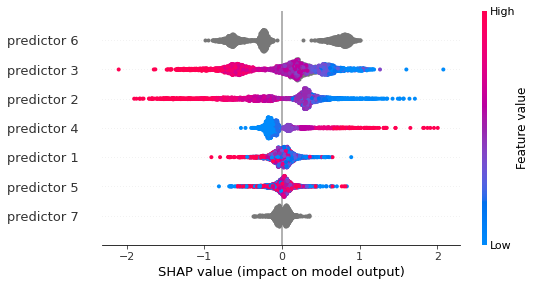

In [ ]:
selector.plot_values()

And also - you can see the feature importance frame

In [ ]:
selector.get_feature_importance()

,col_name,feature_importance_vals
5,predictor 6,0.560596
2,predictor 3,0.464636
1,predictor 2,0.463467
3,predictor 4,0.209312
0,predictor 1,0.104735
4,predictor 5,0.094200
6,predictor 7,0.061994


If you have problems with instalation of shap library - you can take `FeatureSelectionUniversal`, but it only work with feature importance and do not so strong like `shap`

Let us check score. On cross validation with full set and selected

## Full set

In [ ]:
cat_features = list(X_train.select_dtypes(exclude=['int64', 'float64']).columns)

In [ ]:
%%time
estimator = CatBoostClassifier(cat_features=cat_features, verbose=200)
score = cross_validate(estimator, X_train, y_train,
                           scoring=['roc_auc', 'accuracy'],
                           n_jobs=-1, verbose=0)

CPU times: user 335 ms, sys: 105 ms, total: 440 ms
Wall time: 52.7 s


In [ ]:
score['test_roc_auc']

array([0.77993512, 0.76461687, 0.76003427, 0.76213721, 0.77352615])

In [ ]:
score['test_accuracy']

array([0.8155, 0.818 , 0.8135, 0.8225, 0.8205])

## Selected set

In [ ]:
cat_features = list(X.select_dtypes(exclude=['int64', 'float64']).columns)

In [ ]:
%%time
estimator = CatBoostClassifier(cat_features=cat_features, verbose=200)
score = cross_validate(estimator, X, y_train,
                           scoring=['roc_auc', 'accuracy'],
                           n_jobs=-1, verbose=0)

CPU times: user 266 ms, sys: 32.9 ms, total: 299 ms
Wall time: 45 s


In [ ]:
score['test_roc_auc']

array([0.74673154, 0.73817593, 0.74207344, 0.74160373, 0.77454504])

In [ ]:
score['test_accuracy']

array([0.808 , 0.81  , 0.815 , 0.8085, 0.8135])

with different numbers of predictors - we have approximately the same results

## DFwrapper - outliers and corr remover

Let us check the data

In [ ]:
X_train.head()

,predictor 1,predictor 2,predictor 3,predictor 4,predictor 5,predictor 6,predictor 7
0,12423,710,441.5,5,4631.0,D4,B1
1,13983,1106,NaN,3,4256.0,D5,B1
2,15520,1276,391.5,1,4397.0,unknown,B1
3,29535,1106,NaN,1,3772.0,D4,B2
4,26154,976,315.0,5,2445.0,D3,B1


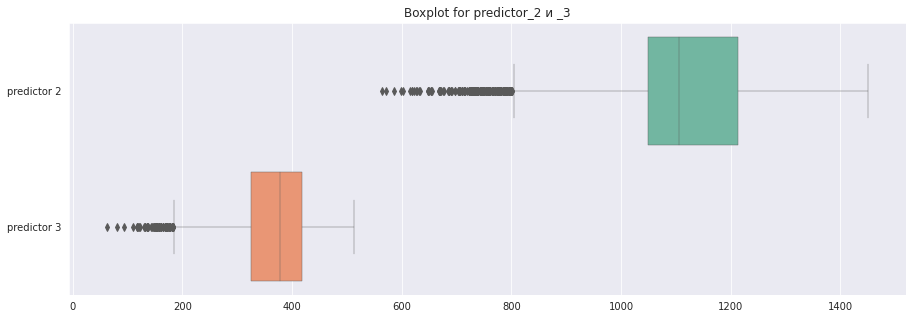

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df[['predictor 2', 'predictor 3']], linewidth=0.42, palette="Set2", orient='h')
plt.title('Boxplot for predictor_2 и _3')
plt.show()

In [ ]:
cols_to_clean = ['predictor 2', 'predictor 3']

Let us delete outliers

In [ ]:
cleaner = DFwrapper(low=.05, high=.95)
cleaned = cleaner.quantile_cleaner(df, cols_to_clean)

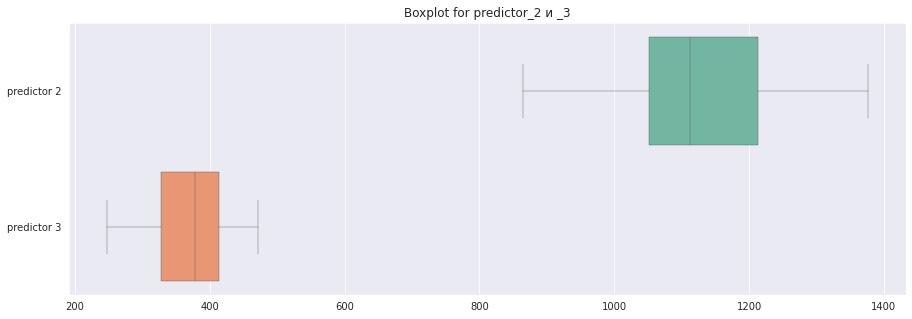

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=cleaned[['predictor 2', 'predictor 3']], linewidth=0.42, palette="Set2", orient='h')
plt.title('Boxplot for predictor_2 и _3')
plt.show()

Another way

In [ ]:
cleaner = DFwrapper(koeff=1.5)
cleaned = cleaner.frame_irq(df, cols_to_clean)

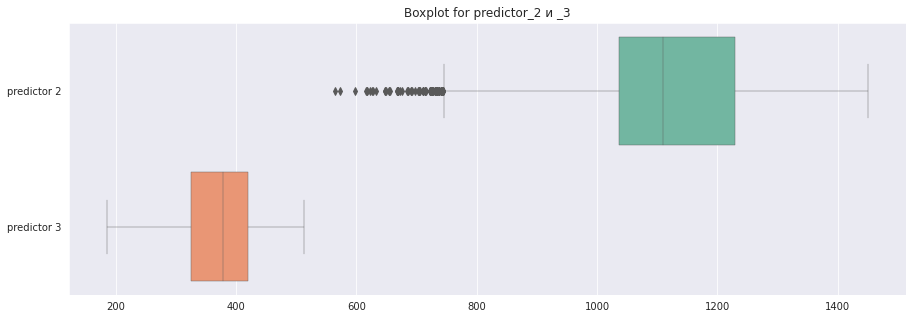

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=cleaned[['predictor 2', 'predictor 3']], linewidth=0.42, palette="Set2", orient='h')
plt.title('Boxplot for predictor_2 и _3')
plt.show()

What about correleation?


In [ ]:
df.phik_matrix().abs()

interval columns not set, guessing: ['predictor 1', 'predictor 2', 'predictor 3', 'predictor 4', 'predictor 5', 'target']


,predictor 1,predictor 2,predictor 3,predictor 4,predictor 5,predictor 6,predictor 7,target
predictor 1,1.000000,0.028502,0.018989,0.025862,0.027389,0.000000,0.000000,0.000000
predictor 2,0.028502,1.000000,0.491745,0.292319,0.000000,0.010465,0.048403,0.336748
predictor 3,0.018989,0.491745,1.000000,0.263915,0.000000,0.063173,0.000000,0.410803
predictor 4,0.025862,0.292319,0.263915,1.000000,0.000000,0.019226,0.000000,0.268093
predictor 5,0.027389,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
predictor 6,0.000000,0.010465,0.063173,0.019226,0.000000,1.000000,0.077546,0.101715
predictor 7,0.000000,0.048403,0.000000,0.000000,0.000000,0.077546,1.000000,0.015491
target,0.000000,0.336748,0.410803,0.268093,0.000000,0.101715,0.015491,1.000000


0.4 - it is kust for example. Usuually, you want to delete > 0.8

In [ ]:
cleaner = DFwrapper(thresh=0.4)
new_df = cleaner.wrap_corr(df)

interval columns not set, guessing: ['predictor 1', 'predictor 2', 'predictor 3', 'predictor 4', 'predictor 5', 'target']


In [ ]:
new_df.phik_matrix().abs()

interval columns not set, guessing: ['predictor 1', 'predictor 2', 'predictor 4', 'predictor 5']


,predictor 1,predictor 2,predictor 4,predictor 5,predictor 6,predictor 7
predictor 1,1.000000,0.028502,0.025862,0.027389,0.000000,0.000000
predictor 2,0.028502,1.000000,0.292319,0.000000,0.010465,0.048403
predictor 4,0.025862,0.292319,1.000000,0.000000,0.019226,0.000000
predictor 5,0.027389,0.000000,0.000000,1.000000,0.000000,0.000000
predictor 6,0.000000,0.010465,0.019226,0.000000,1.000000,0.077546
predictor 7,0.000000,0.048403,0.000000,0.000000,0.077546,1.000000
